
# Dispersion Trading Overview

Dispersion trading is a sophisticated investment strategy that capitalizes on the variance between the implied correlation of index volatilities and the volatilities of its individual constituents. The core premise of this strategy hinges on the mean reversion of implied correlations.

### Methodology

Before diving into the mechanics of establishing a dispersion trade, it's crucial to identify and gather the necessary data:

**Data Required:**
1. ATM (At-the-Money) strike price and implied volatility for the BankNifty index.
2. A selection of bank stocks that constitute at least 80% of the BankNifty index.
3. ATM strike prices and implied volatilities for these chosen index constituents.
4. The weighted implied volatility of these selected index constituents.
5. The implied dirty correlation, calculations are done below.

**Execution of the Mean Reversion Strategy:**
1. **Low Implied Correlation:** Initiate a position by purchasing a straddle on the index and simultaneously selling straddles on the index constituents.
2. **High Implied Correlation:** Establish a position by selling the index straddle and purchasing straddles on the index constituents.
3. **Mean Reversion:** Close out positions once the implied correlation reverts to its mean.

### Getting Started

With the required data in hand and a clear understanding of the operational framework, we are now ready to engage in dispersion trading. This strategy not only leverages fluctuations in volatility but also provides an avenue to exploit the dynamics of correlation reversion, offering a potentially profitable trading setup.

## Import the libraries

In [1]:
!pip install mibian

  Preparing metadata (setup.py) ... done
  Created wheel for mibian: filename=mibian-0.1.3-py3-none-any.whl size=4025 sha256=d96c790c8233b4fcfeaee606b945c08d4e876f42c9d9de066abebf2f940e9b57
  Stored in directory: /root/.cache/pip/wheels/2c/4f/a7/be034e17cc306b0850f5f1a5b4541281b49475c58620a7ff40
Successfully built mibian


In [2]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime

# To calculate Greeks
import mibian

# For Plotting
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

## Determining the Top 5 Constituents of the BankNifty Index
The BankNifty Index comprises several stocks, of which the top 5 have a significant influence on its performance. Below are the top five stocks which collectively account for approximately 82% of the market capitalization of the BankNifty:

* HDFC Bank: 27.52%
* ICICI Bank: 23.84%
* State Bank of India: 10.33%
* Kotak Mahindra Bank: 10.16%
* Axis Bank: 10.14%

These percentages total to an index weight of 82%(approx), demonstrating the substantial concentration of the index in these leading financial entities.

Note: The individual weightage of stocks in an index, along with their corresponding lot sizes, are typically established by the respective stock exchange. The weights and lot sizes presented here were assigned based on the BankNifty composition information available as of 2017. This snapshot provides an illustrative example of how dominant certain constituents can be within the index.



In [3]:
HDFCBANK_Wt = 0.2752
HDFCBANK_Lot_Size = 500

ICICIBANK_Wt = 0.2384
ICICIBANK_Lot_Size = 2500

KOTAKBANK_Wt = 0.1016
KOTAKBANK_Lot_Size = 800

SBIN_Wt = 0.1033
SBIN_Lot_Size = 3000

AXISBANK_Wt = 0.1014
AXISBANK_Lot_Size = 1200

BankNifty_Wt = 1.0
BankNifty_Lot_Size = 40

## Read data


We will do the following tasks:
1. Use pandas to import the CSV file as a data frame
1. Remove strike price of the option which doesn't have Open Interest
1. Only keep columns that are relevant for strategy

In [ ]:
#defining a function to read the csv file
def read_data(inst_name):
    opt = pd.read_csv(inst_name + ".csv")
    fut = pd.read_csv('../data_modules/BankNifty_Options_Data.csv')
    opt = opt[opt['Open Int'] != 0]
    opt = opt[['Symbol', 'Date', 'Expiry', 'Option Type',
               'Strike Price', 'Close', 'futures_price']]
    return opt



BankNifty_Opt = read_data('../data_modules/BankNifty_Options_Data')
BankNifty_Opt = BankNifty_Opt[(BankNifty_Opt.Symbol == 'BANKNIFTY')]

#inspecting the data
BankNifty_Opt.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price
0,BANKNIFTY,01-Dec-17,28-Dec-17,CE,22400.0,2956.0,25259.65
1,BANKNIFTY,01-Dec-17,28-Dec-17,CE,27500.0,8.0,25259.65
6,BANKNIFTY,01-Dec-17,28-Dec-17,CE,23000.0,2249.4,25259.65
7,BANKNIFTY,01-Dec-17,28-Dec-17,CE,23100.0,2266.7,25259.65
8,BANKNIFTY,01-Dec-17,28-Dec-17,CE,23200.0,2320.0,25259.65


## Calculate time to expiry

We convert the trading date ('Date') and expiry date ('Expiry') into datetime object and then, calculate and store the time to expiry in days.

In [ ]:
def time_to_expiry(opt):
    opt.Expiry = pd.to_datetime(opt.Expiry)
    opt.Date = pd.to_datetime(opt.Date)
    opt['time_to_expiry'] = (opt.Expiry - opt.Date).dt.days
    return opt


BankNifty_Opt = time_to_expiry(BankNifty_Opt)
BankNifty_Opt.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry
0,BANKNIFTY,2017-12-01,2017-12-28,CE,22400.0,2956.0,25259.65,27
1,BANKNIFTY,2017-12-01,2017-12-28,CE,27500.0,8.0,25259.65,27
6,BANKNIFTY,2017-12-01,2017-12-28,CE,23000.0,2249.4,25259.65,27
7,BANKNIFTY,2017-12-01,2017-12-28,CE,23100.0,2266.7,25259.65,27
8,BANKNIFTY,2017-12-01,2017-12-28,CE,23200.0,2320.0,25259.65,27


##Determining the ATM Strike Price
Determining the correct ATM strike price is crucial for positioning in ATM straddles effectively. An ATM strike price is identified as the strike closest to the futures price of the underlying asset. Here's how you can determine the ATM strike price:

Steps to Determine the ATM Strike Price:

1. Calculate the Distance: Compute the absolute difference between each available strike price and the futures price of the underlying asset.
2. Identify the Minimum Distance: Select the strike price that has the smallest distance to the futures price. This strike price is considered ATM.

Purpose:
This process ensures that the chosen strike price accurately reflects the current market conditions, allowing traders to engage in ATM straddle positions that are sensitive to price movements of the underlying asset.

In [ ]:
def atm_strike_price(opt):
    # Calculating the absolute difference between the futures price and each strike price
    opt['strike_distance'] = np.abs(opt['futures_price'] - opt['Strike Price'])

    # Identifying the minimum distance for each date
    min_distances = opt.groupby('Date')['strike_distance'].transform(min)

    # Filtering rows where the strike distance matches the minimum distance found
    opt = opt[opt['strike_distance'] == min_distances]

    # Dropping the auxiliary 'strike_distance' column
    opt = opt.drop(columns=['strike_distance'])

    # Removing duplicates to ensure only one ATM option per date, expiry, and option type
    opt = opt.drop_duplicates(subset=['Date', 'Expiry', 'Option Type'])
    return opt

# Assuming 'BankNifty_Opt' is your initial DataFrame containing option data
full_BankNifty_opt = BankNifty_Opt.copy()
BankNifty_Opt = atm_strike_price(BankNifty_Opt)
print(BankNifty_Opt.tail())

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry
199,BANKNIFTY,2017-10-23,2017-10-26,PE,24100.0,147.70,24123.35,3
200,BANKNIFTY,2017-10-24,2017-10-26,CE,24200.0,152.45,24237.55,2
201,BANKNIFTY,2017-10-24,2017-10-26,PE,24200.0,112.75,24237.55,2
202,BANKNIFTY,2017-10-25,2017-10-26,CE,25000.0,112.35,24981.20,1
203,BANKNIFTY,2017-10-25,2017-10-26,PE,25000.0,129.50,24981.20,1


##Calculating P&L from a Long Straddle
A long straddle strategy involves the simultaneous purchase of both an ATM call and an ATM put option with the same strike price and expiration. This strategy profits from significant moves in the underlying asset's price in either direction. Here’s how to calculate the profit and loss (P&L) from this strategy:

Steps to Calculate P&L:
1. Identify the Next Trading Day: Determine the date of the next trading session. This is necessary to assess the change in option prices which affects the straddle's performance.
2. Fetch Next Day’s Option Prices: For both the call and put options purchased, retrieve the prices for the same expiry and strike price as of the next trading day. These are essential to compare against the purchase prices.
3. Compute the Price Differences: Calculate the difference in the option prices from the purchase date to the next trading day. The calculation is performed by subtracting the initial purchase prices from the prices on the following trading day.
4. Record the P&L: Sum the results of the price differences for both the call and the put to determine the overall daily P&L. Store this value in a column named daily_straddle_pnl within your dataset.

Implementation Note:
This methodology assumes that the market conditions allow for the seamless execution of trades at desired prices and that sufficient data regarding option prices is readily available. This calculation provides a straightforward measure of the straddle's performance from one day to the next, highlighting its responsiveness to market volatility.

In [ ]:
def daily_pnl(opt, full_opt):
    opt['next_day_close'] = np.nan
    opt.sort_values('Date', inplace=True, ascending=True)
    for i in range(0, len(opt)-2):
        strike_price = opt.iloc[i]['Strike Price']
        trade_date = opt.iloc[i]['Date']
        next_trading_date = opt[(opt.Date > trade_date)
                                & (opt.Date <= trade_date + datetime.timedelta(days=20)
                                   )].iloc[0]['Date']
        option_type = opt.iloc[i]['Option Type']

        if opt.iloc[i]['time_to_expiry'] != 0:
            opt.iloc[i, opt.columns.get_loc('next_day_close')] = full_opt[(full_opt['Strike Price'] == strike_price) &
                                                                          (full_opt['Date'] == next_trading_date) &
                                                                          (full_opt['Option Type']
                                                                           == option_type)
                                                                          ].iloc[0]['Close']
        else:
            # This is done because on expiry day the next day price doesn't exists
            opt.iloc[i, opt.columns.get_loc(
                'next_day_close')] = opt.iloc[i]['Close']

    opt['daily_straddle_pnl'] = opt.next_day_close - opt.Close
    return opt


BankNifty_Opt = daily_pnl(BankNifty_Opt, full_BankNifty_opt)
BankNifty_Opt.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_pnl
118,BANKNIFTY,2017-07-28,2017-08-31,CE,24900.0,382.00,24934.25,34,509.65,127.65
119,BANKNIFTY,2017-07-28,2017-08-31,PE,24900.0,355.30,24934.25,34,284.35,-70.95
120,BANKNIFTY,2017-07-31,2017-08-31,CE,25100.0,396.60,25135.05,31,420.00,23.40
122,BANKNIFTY,2017-07-31,2017-08-31,PE,25100.0,367.45,25135.05,31,326.70,-40.75
128,BANKNIFTY,2017-08-01,2017-08-31,CE,25200.0,366.15,25195.35,30,320.60,-45.55


#Computing Implied Volatility with Mibian Library
Implied volatility is calculated from the market price of an option using the Black-Scholes model implemented in the mibian Python library. Here's a brief overview of the process:

##Inputs for the Black-Scholes Function:
* Underlying Price: The current market price of the stock or index.
* Strike Price: The option's strike price.
* Risk-Free Rate: The current risk-free interest rate, typically from government securities.
* Time to Expiry: Adjusted to 0.00001 days on the expiry day to avoid computational errors.
* Option Price: The market price of the option.

###Calculation Process:
1. Prepare Inputs: Adjust Time to Expiry on the expiry day for accuracy in volatility and Delta calculations.
2. Invoke BS Function: Use mibian.BS with the prepared inputs to compute the implied volatility.

In [ ]:
def implied_volatility_options(opt):
    opt['IV'] = np.nan
    opt = opt.iloc[:3]
    opt.loc[(opt.time_to_expiry == 0), 'time_to_expiry'] = 0.0000001
    for i in range(0, len(opt)):
        if opt.iloc[i]['Option Type'] == 'CE':
            opt.iloc[i, opt.columns.get_loc('IV')] = mibian.BS([opt.iloc[i]['futures_price'],
                                                                opt.iloc[i]['Strike Price'],
                                                                0,
                                                                opt.iloc[i]['time_to_expiry']],
                                                               callPrice=opt.iloc[i]['Close']
                                                               ).impliedVolatility
        else:
            opt.iloc[i, opt.columns.get_loc('IV')] = mibian.BS([opt.iloc[i]['futures_price'],
                                                                opt.iloc[i]['Strike Price'],
                                                                0,
                                                                opt.iloc[i]['time_to_expiry']],
                                                               putPrice=opt.iloc[i]['Close']
                                                               ).impliedVolatility
    return opt


'''
Since this process is computationally heavy, we will calculate the implied volatility for first 3 rows and
import the remaining implied volatility data from the BankNifty_Preprocessed_Options_Data csv file.
In BankNifty_Preprocessed_Options_Data csv file, we have already computed and stored the implied volatility data in it.
'''
BankNifty_Opt.iloc[:3] = implied_volatility_options(BankNifty_Opt)
opt_IV = pd.read_csv(
    '../data_modules/BankNifty_Preprocessed_Options_Data.csv', index_col=0)
BankNifty_Opt = opt_IV[(opt_IV.Symbol == BankNifty_Opt.Symbol.iloc[0])]
BankNifty_Opt.tail()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_pnl,IV,delta
14,BANKNIFTY,2017-12-12,2017-12-28,CE,25200.0,331.60,25178.20,16.0,296.4,-35.2,16.273499,0.496663
16,BANKNIFTY,2017-12-13,2017-12-28,CE,25000.0,393.60,25038.20,15.0,513.2,119.6,18.493652,0.523712
17,BANKNIFTY,2017-12-13,2017-12-28,PE,25000.0,368.40,25038.20,15.0,312.9,-55.5,19.138336,-0.476575
19,BANKNIFTY,2017-12-14,2017-12-28,PE,25200.0,384.55,25213.05,14.0,NaN,NaN,19.856930,-0.486934
18,BANKNIFTY,2017-12-14,2017-12-28,CE,25200.0,391.35,25213.05,14.0,NaN,NaN,19.539356,0.513028


## Computing Delta

Similar to implied volatility, we will compute the Delta of the straddle using mibian library BS function.

In [ ]:
def delta_options(opt):
    # Initializing the 'delta' column with NaN values
    opt['delta'] = np.nan

    # Processing only the first three rows for performance reasons
    opt = opt.iloc[:3]

    # Iterating through each of the first three rows to calculate Delta
    for i in range(len(opt)):
        # Accessing the necessary data for each option
        futures_price = opt.iloc[i]['futures_price']
        strike_price = opt.iloc[i]['Strike Price']
        time_to_expiry = opt.iloc[i]['time_to_expiry']
        implied_volatility = opt.iloc[i]['IV']
        option_type = opt.iloc[i]['Option Type']

        # Determining the option type and calculating Delta accordingly
        if option_type == 'CE':  # CE indicates a call option
            delta = mibian.BS([futures_price, strike_price, 0, time_to_expiry],
                              volatility=implied_volatility).callDelta
        else:  # Assume put option
            delta = mibian.BS([futures_price, strike_price, 0, time_to_expiry],
                              volatility=implied_volatility).putDelta

        # Assigning the calculated Delta back to the DataFrame
        opt.at[i, 'delta'] = delta

    return opt

'''
Since this process is computationally heavy, we will calculate the Delta for first 3 rows and
the remaining Delta data is already imported from the BankNifty_Preprocessed_Options_Data csv file in the previous step.
'''
BankNifty_Opt.iloc[:3] = delta_options(BankNifty_Opt)
BankNifty_Opt.tail(6)


,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_pnl,IV,delta
15,BANKNIFTY,2017-12-12,2017-12-28,PE,25200.0,358.90,25178.20,16.0,463.0,104.1,16.536713,NaN
14,BANKNIFTY,2017-12-12,2017-12-28,CE,25200.0,331.60,25178.20,16.0,296.4,-35.2,16.273499,NaN
16,BANKNIFTY,2017-12-13,2017-12-28,CE,25000.0,393.60,25038.20,15.0,513.2,119.6,18.493652,NaN
17,BANKNIFTY,2017-12-13,2017-12-28,PE,25000.0,368.40,25038.20,15.0,312.9,-55.5,19.138336,NaN
19,BANKNIFTY,2017-12-14,2017-12-28,PE,25200.0,384.55,25213.05,14.0,NaN,NaN,19.856930,NaN
18,BANKNIFTY,2017-12-14,2017-12-28,CE,25200.0,391.35,25213.05,14.0,NaN,NaN,19.539356,NaN


## Reading data and preprocessing BankNifty constituents stocks data

We will do same steps for BankNifty constituents stocks that we followed to read and preprocess the data for BankNifty above.

In [ ]:
def read_constituents_data(inst_name):
    opt = read_data(inst_name)
    opt = time_to_expiry(opt)

    HDFCBANK_Opt = opt[(opt.Symbol == 'HDFCBANK')]
    ICICIBANK_Opt = opt[(opt.Symbol == 'ICICIBANK')]
    KOTAKBANK_Opt = opt[(opt.Symbol == 'KOTAKBANK')]
    SBIN_Opt = opt[(opt.Symbol == 'SBIN')]
    AXISBANK_Opt = opt[(opt.Symbol == 'AXISBANK')]

    return HDFCBANK_Opt, ICICIBANK_Opt, KOTAKBANK_Opt, SBIN_Opt, AXISBANK_Opt


HDFCBANK_Opt, ICICIBANK_Opt, KOTAKBANK_Opt, SBIN_Opt, AXISBANK_Opt = read_constituents_data(
    '../data_modules/BankNifty_Options_Data')
HDFCBANK_Opt.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry
15942,HDFCBANK,2017-12-01,2017-12-28,CE,1600.0,258.0,1846.85,27
15945,HDFCBANK,2017-12-01,2017-12-28,CE,1660.0,195.0,1846.85,27
15946,HDFCBANK,2017-12-01,2017-12-28,CE,1680.0,181.0,1846.85,27
15947,HDFCBANK,2017-12-01,2017-12-28,CE,1700.0,161.5,1846.85,27
15948,HDFCBANK,2017-12-01,2017-12-28,CE,1720.0,142.0,1846.85,27


In [ ]:
def preprocess(opt):
    full_opt = opt
    opt = atm_strike_price(opt)
    opt = daily_pnl(opt, full_opt)
    return opt


HDFCBANK_Opt = preprocess(HDFCBANK_Opt)
ICICIBANK_Opt = preprocess(ICICIBANK_Opt)
KOTAKBANK_Opt = preprocess(KOTAKBANK_Opt)
SBIN_Opt = preprocess(SBIN_Opt)
AXISBANK_Opt = preprocess(AXISBANK_Opt)
HDFCBANK_Opt.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_pnl
192,HDFCBANK,2017-07-28,2017-08-31,CE,1780.0,37.7,1783.45,34,35.5,-2.2
193,HDFCBANK,2017-07-28,2017-08-31,PE,1780.0,35.1,1783.45,34,36.8,1.7
195,HDFCBANK,2017-07-31,2017-08-31,PE,1780.0,36.8,1778.75,31,26.8,-10.0
194,HDFCBANK,2017-07-31,2017-08-31,CE,1780.0,35.5,1778.75,31,41.7,6.2
197,HDFCBANK,2017-08-01,2017-08-31,PE,1800.0,34.6,1795.95,30,36.1,1.5


In [ ]:
def greeks(opt):
    '''
    Since the process to compute the implied volatility and Delta is time consuming,
    we will import the implied volatility and Delta data from the BankNifty_Preprocessed_Options_Data csv file.
    '''
    #opt = implied_volatility_options(opt)
    #opt = delta_options(opt)
    opt_IV = pd.read_csv(
        '../data_modules/BankNifty_Preprocessed_Options_Data.csv', index_col=0)
    opt = opt_IV[(opt_IV.Symbol == opt.Symbol.iloc[0])]
    return opt


HDFCBANK_Opt = greeks(HDFCBANK_Opt)
ICICIBANK_Opt = greeks(ICICIBANK_Opt)
KOTAKBANK_Opt = greeks(KOTAKBANK_Opt)
SBIN_Opt = greeks(SBIN_Opt)
AXISBANK_Opt = greeks(AXISBANK_Opt)
HDFCBANK_Opt.tail()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_pnl,IV,delta
27,HDFCBANK,2017-12-12,2017-12-28,PE,1820.0,21.80,1823.05,16.0,24.75,2.95,15.319824,-0.472797
28,HDFCBANK,2017-12-13,2017-12-28,CE,1820.0,27.15,1822.15,15.0,35.10,7.95,17.696381,0.520276
30,HDFCBANK,2017-12-13,2017-12-28,PE,1820.0,24.75,1822.15,15.0,17.45,-7.30,17.524719,-0.479665
36,HDFCBANK,2017-12-14,2017-12-28,CE,1840.0,23.80,1837.80,14.0,NaN,NaN,17.333984,0.492713
37,HDFCBANK,2017-12-14,2017-12-28,PE,1840.0,25.35,1837.80,14.0,NaN,NaN,16.868591,-0.507857


## Delta hedging
It is important to keep the Delta close to zero. The Delta can be hedged using the future contracts to keep the whole process Delta neutral. When the Delta goes above 1, one future contract is sold and vice-versa, when the Delta drops to -1, one futures contract is bought.

In [ ]:
HDFCBANK_delta = HDFCBANK_Opt.groupby(['Date'])['delta'].sum().to_frame()
HDFCBANK_delta.tail()

,delta
Date,
2017-12-08,-0.003085
2017-12-11,0.041589
2017-12-12,0.054127
2017-12-13,0.040612
2017-12-14,-0.015144


----------------------------------------------------------
#####Since, we are buying or selling straddle the Delta is close to zero and therefore, Delta hedging with future is skipped in this strategy.     
----------------------------------------------------------

## Implied dirty correlation

This is the square of the ratio of the implied volatility of index and the weighted average of stocks. The formula is given as below

$\text{Implied Dirty Correlation} = \left(\frac{\text{Implied Volatility of Index}}{\text{Weighted Average Volatility of Stocks}}\right)^2$

Following steps are followed in below function (implied_dirty_correlation):
1. For each day the average of implied volatility (IV) for ATM Call and ATM Put is calculated for BankNifty and its constituents
2. Then, weighted average constituents volatility is calculated
3. Finally, the implied correlation is calculated as the index implied volatility and weighted average constituents volatility

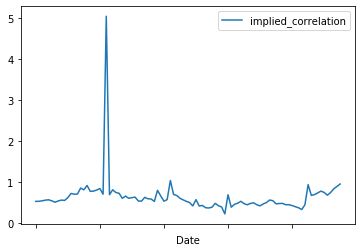

In [ ]:
def implied_dirty_correlation():
    BankNifty_IV = BankNifty_Opt.groupby(['Date'])['IV'].mean().to_frame()

    HDFCBANK_IV = HDFCBANK_Opt.groupby(['Date'])['IV'].mean().to_frame()
    ICICIBANK_IV = ICICIBANK_Opt.groupby(['Date'])['IV'].mean().to_frame()
    KOTAKBANK_IV = KOTAKBANK_Opt.groupby(['Date'])['IV'].mean().to_frame()
    SBIN_IV = SBIN_Opt.groupby(['Date'])['IV'].mean().to_frame()
    AXISBANK_IV = AXISBANK_Opt.groupby(['Date'])['IV'].mean().to_frame()

    weighted_average_constituents_vol = HDFCBANK_IV * HDFCBANK_Wt + \
        SBIN_IV * SBIN_Wt + \
        ICICIBANK_IV * ICICIBANK_Wt + \
        KOTAKBANK_IV * KOTAKBANK_Wt + \
        AXISBANK_IV * AXISBANK_Wt

    return (BankNifty_IV/weighted_average_constituents_vol)**2


df = implied_dirty_correlation()
df = df.rename(columns={'IV': 'implied_correlation'})
df.plot()
plt.show()

The spike in the implied correlation of 5 is on the expiry day which can be ignored as we are not taking any position on expiry day.

#Backtesting the Dispersion Trading Strategy
Backtesting allows us to assess the efficacy of the dispersion trading strategy by simulating trades using historical data. This process involves establishing positions based on the historical implied correlations and evaluating how these positions would have performed.

###Establishing Options Positions
The strategy hinges on the relative values of implied correlation compared to its historical mean. Positions are established based on whether the implied correlation deviates from the mean by more than half a standard deviation:

* High Implied Correlation: When the index's implied volatility exceeds that of its constituents by at least half a standard deviation, a short position is initiated on the index's volatility (selling index straddle) and a long position on the constituents' volatility (buying constituent straddles). This setup expects the high correlation to revert to mean, decreasing the index volatility relative to its constituents.
* Low Implied Correlation: Conversely, if the index's implied volatility is significantly below that of the constituents (less than half a standard deviation from the mean), the strategy calls for buying the index straddle and selling the constituent straddles. This position anticipates an increase in index volatility relative to its constituents.

###Signal Representation
Positions are numerically represented for clarity and ease of evaluation:

1. '+1': Indicates a long volatility position on the index and a short position on the constituents.
2. '-1': Represents a short volatility position on the index and a long position on the constituents.
3. '0': Used to denote the closure of all open positions in both the index and its constituents.

In [ ]:
def trading_signal(df):
    df.index.column = 0

    lookback = 5
    # Moving Average
    df['moving_average'] = df['implied_correlation'].rolling(lookback).mean()
    # Moving Standard Deviation
    df['moving_std_dev'] = df['implied_correlation'].rolling(lookback).std()

    df['upper_band'] = df.moving_average + 0.5*df.moving_std_dev
    df['lower_band'] = df.moving_average - 0.5*df.moving_std_dev

    df['long_entry'] = df.implied_correlation < df.lower_band
    df['long_exit'] = df.implied_correlation >= df.moving_average

    df['short_entry'] = df.implied_correlation > df.upper_band
    df['short_exit'] = df.implied_correlation <= df.moving_average

    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0

    expiry_dates = HDFCBANK_Opt.Expiry.unique()
    df.loc[df.index.isin(expiry_dates), 'positions_short'] = 0

    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0

    df.loc[df.index.isin(expiry_dates), 'positions_short'] = 0

    df = df.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short

    return df


df = trading_signal(df)
df.positions.tail()

Date
2017-12-08    1.0
2017-12-11    0.0
2017-12-12   -1.0
2017-12-13   -1.0
2017-12-14   -1.0
Name: positions, dtype: float64

### Strategy PnL

The strategy PnL is calculated by multiplying the positions with the daily PnL of the long straddle computed earlier.

In [ ]:
def strategy_pnl(opt, df):
    opt = pd.merge(opt, df[['positions']], left_on='Date',
                   right_index=True, how='left')
    opt['strategy_pnl'] = opt.positions * opt.daily_straddle_pnl
    return opt


BankNifty_Opt = strategy_pnl(BankNifty_Opt, df)
BankNifty_Opt.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_pnl,IV,delta,positions,strategy_pnl
118,BANKNIFTY,2017-07-28,2017-08-31,CE,24900.0,382.00,24934.25,34.0,509.65,127.65,12.020111,0.522254,NaN,NaN
119,BANKNIFTY,2017-07-28,2017-08-31,PE,24900.0,355.30,24934.25,34.0,284.35,-70.95,12.268066,-0.477897,NaN,NaN
120,BANKNIFTY,2017-07-31,2017-08-31,CE,25100.0,396.60,25135.05,31.0,420.00,23.40,12.973785,0.522254,NaN,NaN
122,BANKNIFTY,2017-07-31,2017-08-31,PE,25100.0,367.45,25135.05,31.0,326.70,-40.75,13.175011,NaN,NaN,NaN
128,BANKNIFTY,2017-08-01,2017-08-31,CE,25200.0,366.15,25195.35,30.0,320.60,-45.55,12.786388,NaN,NaN,NaN


Since, we need to take opposite position in the index constituents compared to index, we will multiply the positions with -1 and compute the strategy returns of the index constituents.

In [ ]:
df.positions *= -1
HDFCBANK_Opt = strategy_pnl(HDFCBANK_Opt, df)
ICICIBANK_Opt = strategy_pnl(ICICIBANK_Opt, df)
KOTAKBANK_Opt = strategy_pnl(KOTAKBANK_Opt, df)
SBIN_Opt = strategy_pnl(SBIN_Opt, df)
AXISBANK_Opt = strategy_pnl(AXISBANK_Opt, df)
HDFCBANK_Opt.tail()

,Symbol,Date,Expiry,Option Type,Strike Price,Close,futures_price,time_to_expiry,next_day_close,daily_straddle_pnl,IV,delta,positions,strategy_pnl
27,HDFCBANK,2017-12-12,2017-12-28,PE,1820.0,21.80,1823.05,16.0,24.75,2.95,15.319824,-0.472797,1.0,2.95
28,HDFCBANK,2017-12-13,2017-12-28,CE,1820.0,27.15,1822.15,15.0,35.10,7.95,17.696381,0.520276,1.0,7.95
30,HDFCBANK,2017-12-13,2017-12-28,PE,1820.0,24.75,1822.15,15.0,17.45,-7.30,17.524719,-0.479665,1.0,-7.30
36,HDFCBANK,2017-12-14,2017-12-28,CE,1840.0,23.80,1837.80,14.0,NaN,NaN,17.333984,0.492713,1.0,NaN
37,HDFCBANK,2017-12-14,2017-12-28,PE,1840.0,25.35,1837.80,14.0,NaN,NaN,16.868591,-0.507857,1.0,NaN


We add the PnL from call and put for each day to determine the strategy PnL for BankNifty and its constituents.

In [ ]:
BankNifty_Ret = BankNifty_Opt.groupby(
    ['Date'])['strategy_pnl'].sum().to_frame()

HDFCBANK_Ret = HDFCBANK_Opt.groupby(['Date'])['strategy_pnl'].sum().to_frame()

ICICIBANK_Ret = ICICIBANK_Opt.groupby(
    ['Date'])['strategy_pnl'].sum().to_frame()

KOTAKBANK_Ret = KOTAKBANK_Opt.groupby(
    ['Date'])['strategy_pnl'].sum().to_frame()

SBIN_Ret = SBIN_Opt.groupby(['Date'])['strategy_pnl'].sum().to_frame()

AXISBANK_Ret = AXISBANK_Opt.groupby(['Date'])['strategy_pnl'].sum().to_frame()

BankNifty_Ret.tail()

,strategy_pnl
Date,
2017-12-08,-11.7
2017-12-11,0.0
2017-12-12,-68.9
2017-12-13,-64.1
2017-12-14,0.0


In [ ]:
HDFCBANK_Ret.tail()

,strategy_pnl
Date,
2017-12-08,3.90
2017-12-11,0.00
2017-12-12,4.80
2017-12-13,0.65
2017-12-14,0.00


Here we compute the weighted average PnL of the BankNifty and its constituents. The weight is the weight of the stock in BankNifty.

In [ ]:
def strategy_pnl():
    strategy_pnl = HDFCBANK_Ret.strategy_pnl * HDFCBANK_Lot_Size * HDFCBANK_Wt + \
        SBIN_Ret.strategy_pnl * SBIN_Lot_Size * SBIN_Wt + \
        AXISBANK_Ret.strategy_pnl * AXISBANK_Lot_Size * AXISBANK_Wt + \
        KOTAKBANK_Ret.strategy_pnl * KOTAKBANK_Lot_Size * KOTAKBANK_Wt + \
        ICICIBANK_Ret.strategy_pnl * ICICIBANK_Lot_Size * ICICIBANK_Wt + \
        BankNifty_Ret.strategy_pnl * BankNifty_Lot_Size * BankNifty_Wt
    return strategy_pnl.cumsum().shift(1)

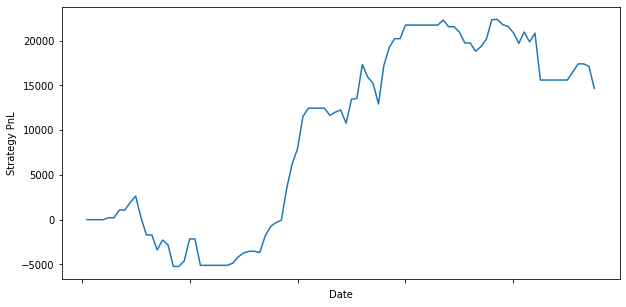

In [ ]:
strategy_pnl().plot(figsize=(10, 5))
plt.ylabel("Strategy PnL")
plt.show()



##**Dispersion Trading Strategy Overview**

Dispersion trading is a sophisticated strategy known for its complexity but also for its potential profitability, offering high rewards in response to relatively low risk. To further enhance the effectiveness of this strategy, it is advisable to decrease the time intervals used to capture the implied volatility and the corresponding dirty implied correlation more frequently. This adjustment allows for a more responsive and dynamic trading approach, adapting quickly to market changes.

<BR>
    